# Phase-Field Crystal model with in-plane coupling: Two dislocations (dipole)

In [1]:
#!/usr/bin/env python
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import os
from scipy.ndimage import gaussian_filter
from functions import *

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 17})
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=14)

## Create the mesh

In [2]:
N = 128
px = 4*np.pi/np.sqrt(3); py = 2*np.pi;
Na = 20; #20
Lx = py*(Na+1)
Ly = py*(Na+1) 
x = np.linspace(-Lx/2,Lx/2,N,endpoint=True); y=x; xm, ym = np.meshgrid(x, y); dx=Lx/N
I = complex(0,1)
kx=2*np.pi*np.fft.fftfreq(N,Lx/N)
ky=2*np.pi*np.fft.fftfreq(N,Ly/N)
kx1 = np.zeros((N,N), dtype=complex);ky1 = np.zeros((N,N), dtype=complex)
kx2 = np.zeros((N,N), dtype=complex);ky2 = np.zeros((N,N), dtype=complex)
for i in range(N):
    for j in range(N):
        kx1[i,j]=kx[i]
        ky1[i,j]=ky[j]
        kx2[i,j]=kx[i]**2
        ky2[i,j]=ky[j]**2

## Initial condition for $\psi$

In [3]:
uux=np.zeros((N,N))
uuy=np.zeros((N,N))
uux,uuy=u_dipole(xm,ym,Lx)

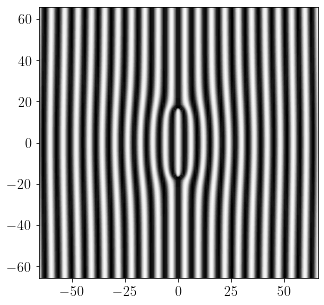

In [4]:
####
# Plot Initial Condition
####
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
phi=0.5*(1-np.tanh(3*(np.sqrt(xm*xm+ym*ym)-3.0*px)/(3*px)))
theta_pert=0*np.pi/180
fun=np.real(np.exp(1j*np.cos(theta_pert)*xm+1j*np.sin(theta_pert)*ym)*np.exp(1j*np.cos(theta_pert)*uux+1j*np.sin(theta_pert)*uuy))
axes.contourf(xm,ym,fun,50,cmap="Greys")

## Set Model Parameters

In [5]:
#Parameters
eps=0.5
nu = 0.333
psibar=0.0
AA = (2./3.)*np.sqrt(3*eps-9*psibar**2)
alpha=1.
ceta=0.0
betain=0.5
beta=betain
gamma=2.0
sigma=0.1
EnergyAC=[]
PosDef=[]
Bx=beta*np.cos(np.pi)
By=beta*np.sin(np.pi)

## Time discretization

In [6]:
#Time discretization
time=400
t=0
dt=0.1
Nt=int(time/dt)
nplot=1000
tvec=np.zeros(Nt)

## Create folder

In [7]:
foldername="./DIP_a"+str(alpha)+"_b"+str(beta)+"_g"+str(gamma)+"_s"+str(sigma)+"_e"+str(eps)+"_Na"+str(Na)
os.makedirs(foldername,exist_ok=True)

## Set initial condition for $\psi$ and $\theta$

In [8]:
theta = np.ones((N,N))*0.0

uini = psibar+AA*fun#*(ym<0)
u=uini

## Run dynamic equations

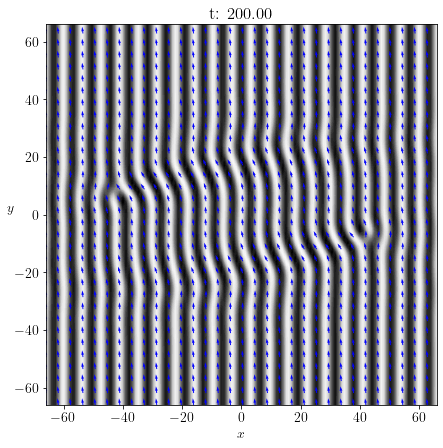

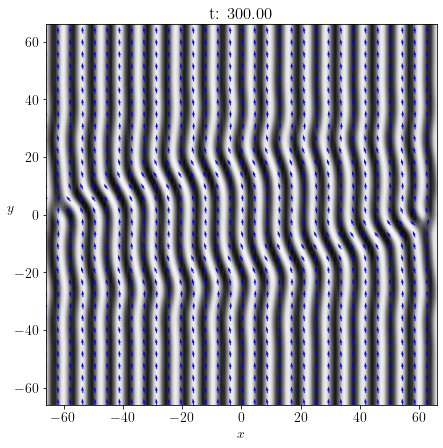

In [9]:
u_all = []
theta_all = []

sq=4

for i in range(Nt):
    uhat = np.fft.fft2(u)
    thetahat = np.fft.fft2(theta)
    #
    GRADu_x=ddFF(u,kx1,ky1,1,0)
    GRADu_y=ddFF(u,kx1,ky1,0,1)
    u3=np.array(u**3, dtype=complex)
    u3_hat=np.fft.fft2(-u3) 
    modG=(GRADu_x**2+GRADu_y**2)
    #
    NL_u=u3_hat+np.fft.fft2(En_NL_u(u,theta,kx1,ky1,GRADu_x,GRADu_y,gamma,Bx,By))
    NL_theta=np.fft.fft2(En_NL_theta(u,theta,GRADu_x,GRADu_y,gamma,Bx,By))
    #
    uhat,thetahat=SH2D_FT_lin(uhat,thetahat,NL_u,NL_theta,kx2,ky2,dt,eps,alpha,sigma)
    u=np.real(np.fft.ifft2(uhat))
    theta=np.real(np.fft.ifft2(thetahat))
    tvec[i]=t
    if(i%nplot==0):
        #Energy
        EnMap=energyFT(u,theta,kx1,ky1,eps,alpha,gamma,sigma,Bx,By,GRADu_x,GRADu_y,0,0,dx)
        EnMapCoarse=gaussian_filter(EnMap, sigma=2*np.pi)
        EnergyAC=np.append(EnergyAC,np.sum(EnMap))
        np.savetxt(foldername+"/energy.txt", EnergyAC, fmt='%.2f')
        #
        #Saving & aux.
        plt.savefig(foldername+"/psi_"+str(i*dt)+".png",dpi=300)
        clear_output(wait=True)
        plt.pause(0.05)
        plt.close()
        np.save(foldername+"/u"+str(i),u)
        np.save(foldername+"/theta"+str(i),theta)
        #
        #
        #Plot solution
        fig, axes = plt.subplots(1, 1, figsize=(7, 7))
        axes.contourf(xm,ym,u,50,cmap='Greys')
        # axes.quiver(xm[::sq,::sq],ym[::sq,::sq],np.cos(theta[::sq,::sq]),np.sin(theta[::sq,::sq]),color = 'red')
        axes.quiver(xm[::sq,::sq],ym[::sq,::sq],-np.sin(theta[::sq,::sq]),np.cos(theta[::sq,::sq]),color = 'blue')
        axes.set_title('t: '+"{:.2f}".format(dt*i))
        axes.set_ylabel('$y$',size=14,rotation=0)
        axes.set_xlabel('$x$',size=14)
        #
        #
        u_all.append(u)
        theta_all.append(theta)
    t=t+dt;


## Visualize the propagation of the dislocations

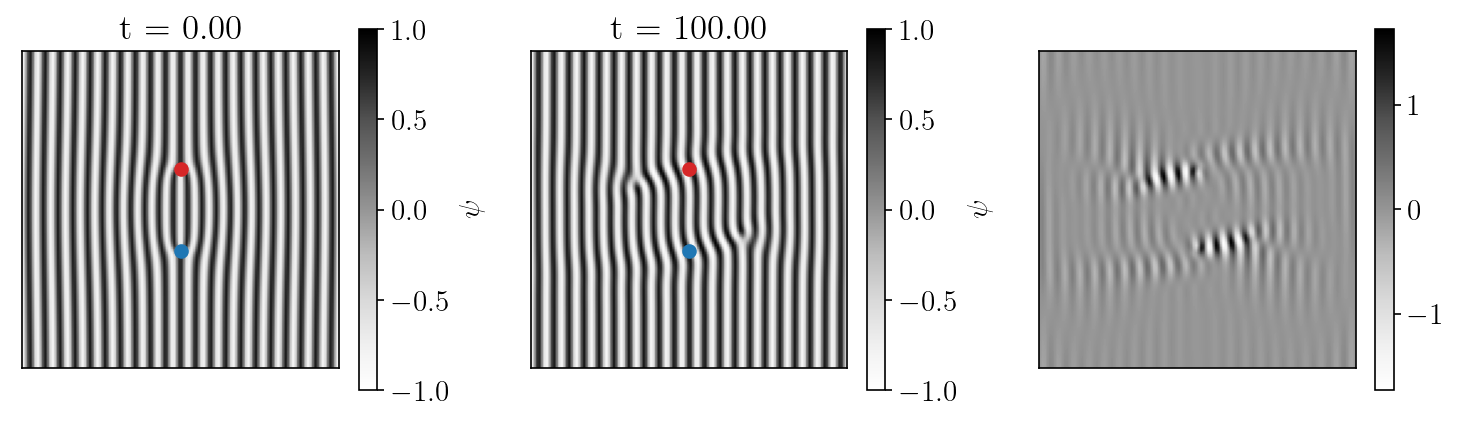

In [10]:
i1 = 0
i2 = 1
plt.figure(figsize=(10,3), dpi=150)
plt.subplot(131)
# plt.title('t = 0')
plt.title('t = '+"{:.2f}".format(dt*i1*nplot))
plt.imshow(u_all[i1],cmap='Greys',vmin=-1,vmax=1,origin='lower')
plt.colorbar(label='$\psi$')
plt.scatter(Lx//2-1.5,Lx//2+15, color='tab:red')
plt.scatter(Lx//2-1.5,Lx//2-18, color='tab:blue')
plt.xticks(())
plt.yticks(())
plt.subplot(132)
# plt.title('t = 1900')
plt.title('t = '+"{:.2f}".format(dt*i2*nplot))
plt.imshow(u_all[i2],cmap='Greys',vmin=-1,vmax=1,origin='lower')
plt.colorbar(label='$\psi$')
plt.scatter(Lx//2-1.5,Lx//2+15, color='tab:red')
plt.scatter(Lx//2-1.5,Lx//2-18, color='tab:blue')
plt.xticks(())
plt.yticks(())
plt.subplot(133)
plt.imshow(u_all[i1] - u_all[i2],cmap='Greys',origin='lower')
plt.colorbar()
plt.xticks(())
plt.yticks(())
plt.tight_layout()